In [3]:
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from importlib import reload

In [4]:
%matplotlib inline

In [5]:
current_dir = os.getcwd()
datadir = os.path.join(Path(current_dir).parents[1], "DimaERC2")
assert os.path.isdir(datadir)

In [6]:
datadir

'/home/mickey/Documents/Theotime/DimaERC2'

In [7]:
current_dir

'/home/mickey/Documents/Theotime/neuroEncoders/notebooks'

In [49]:
# What Basile did
BasileMiceNumber = [
    "1239vBasile",
    "1281vBasile",
    "1199",
    "1336",
    "1168MFB",
    "905",
    "1161w1199",
    "1161",
    "1124",
    "1186",
    "1182",
    "1168UMaze",
    "1117",
    "994",
    "1336v3",
    "1336v2",
    "1281v2",
    "1239v3",
]

# What Dima did according to Baptiste
DimaMiceNumber = [
    "905",
    "906",
    "911",
    "994",
    "1161",
    "1162",
    "1168",
    "1186",
    "1230",
    "1239",
]

# Files wrt to datadir
path_list = [
    "TEST3_Basile_M1239/TEST",
    "TEST3_Basile_1281MFB/TEST",
    "TEST1_Basile/TEST",
    "Known_M1336/TEST/",
    # "DataERC2/M994/20191013/TEST/",
    # "DataERC2/M906/TEST/",
    "DataERC2/M1168/TEST/",
    "DataERC2/M905/TEST/",
    "DataERC2/M1161/TEST_with_1199_model/",
    "DataERC2/M1161/TEST initial/",
    "DataERC2/M1124/TEST/",
    "DataERC2/M1186/TEST/",
    "DataERC2/M1182/TEST/",
    "DataERC1/M1168/TEST/",
    "DataERC1/M1117/TEST/",
    "neuroencoders_1021/_work/M994_PAG/Final_results_v3",
    "neuroencoders_1021/_work/M1336_MFB/Final_results_v3",
    "neuroencoders_1021/_work/M1336_known/Final_results_v2",
    "neuroencoders_1021/_work/M1281_MFB/Final_results_v2",
    "neuroencoders_1021/_work/M1239_MFB/Final_results_v3",
]
assert len(BasileMiceNumber) == len(path_list)
len(BasileMiceNumber)
path_dict = dict(zip(BasileMiceNumber, path_list))

In [59]:
path_dict

{'1239vBasile': 'TEST3_Basile_M1239/TEST',
 '1281vBasile': 'TEST3_Basile_1281MFB/TEST',
 '1199': 'TEST1_Basile/TEST',
 '1336': 'Known_M1336/TEST/',
 '1168MFB': 'DataERC2/M1168/TEST/',
 '905': 'DataERC2/M905/TEST/',
 '1161w1199': 'DataERC2/M1161/TEST_with_1199_model/',
 '1161': 'DataERC2/M1161/TEST initial/',
 '1124': 'DataERC2/M1124/TEST/',
 '1186': 'DataERC2/M1186/TEST/',
 '1182': 'DataERC2/M1182/TEST/',
 '1168UMaze': 'DataERC1/M1168/TEST/',
 '1117': 'DataERC1/M1117/TEST/',
 '994': 'neuroencoders_1021/_work/M994_PAG/Final_results_v3',
 '1336v3': 'neuroencoders_1021/_work/M1336_MFB/Final_results_v3',
 '1336v2': 'neuroencoders_1021/_work/M1336_known/Final_results_v2',
 '1281v2': 'neuroencoders_1021/_work/M1281_MFB/Final_results_v2',
 '1239v3': 'neuroencoders_1021/_work/M1239_MFB/Final_results_v3'}

In [54]:
conditions = {
    "MFB": ["1281vBasile", "1281v3" "1239vBasile", "1239v3", "1336v3", "1336v2"],
    "Known": ["1336", "1336v3"],
    "PAG": ["1186", "1161", "1161w1199", "1124", "1186", "1117", "1199", "994"],
    "Umaze": ["1199", "906", "1168", "905", "1182"],
    # WARNING: 994 has non-aligned nnbehavior.positions; hence the results should not be trusted
    # same for 1239v3
}

list_windows = [36, 108, 200, 252, 504]

In [55]:
import sys

sys.path.append("..")
from importData.rawdata_parser import DataHelper
from resultAnalysis.print_results import print_results

In [56]:
list_windows

[36, 108, 200, 252, 504]

In [57]:
keys_to_include = set()
for mouse, path in path_dict.items():
    path = os.path.join(datadir, path, "../")
    if len(glob.glob(path + "*.dat")) >= 1:
        keys_to_include.add(mouse)

dath_dict = {k: path_dict[k] for k in keys_to_include}

In [58]:
dath_dict

{'1336': 'Known_M1336/TEST/',
 '994': 'neuroencoders_1021/_work/M994_PAG/Final_results_v3',
 '1186': 'DataERC2/M1186/TEST/',
 '1199': 'TEST1_Basile/TEST',
 '1117': 'DataERC1/M1117/TEST/',
 '1239v3': 'neuroencoders_1021/_work/M1239_MFB/Final_results_v3',
 '1336v3': 'neuroencoders_1021/_work/M1336_MFB/Final_results_v3',
 '1281v2': 'neuroencoders_1021/_work/M1281_MFB/Final_results_v2',
 '1168UMaze': 'DataERC1/M1168/TEST/',
 '1182': 'DataERC2/M1182/TEST/',
 '1336v2': 'neuroencoders_1021/_work/M1336_known/Final_results_v2'}

In [28]:
# bypass to avoid heavy comput and fill the memory for nothing
force = False

todo = dict()
dirmouse = dict()
mouse_id = []
windowMS = []
mean_eucl = []
select_eucl = []
mean_lin = []
select_lin = []
has_dat = []
for mouse in BasileMiceNumber:
    todo[mouse] = []
    returned = False
    dirmouse[mouse] = os.path.join(datadir, path_dict[mouse], "results")
    assert os.path.isdir(dirmouse[mouse])
    for win in list_windows:
        try:
            mean, select, linmean, linselect = print_results(
                dirmouse[mouse], show=False, windowSizeMS=win, force=False
            )
            mean_eucl.append(mean)
            select_eucl.append(select)
            mean_lin.append(linmean)
            select_lin.append(linselect)
            mouse_id.append(mouse)
            windowMS.append(win)
            has_dat.append(mouse in dath_dict)
            returned = True
        except Exception as e:
            print(e)
            todo[mouse].append(win)
            print(f"Available windows: {os.listdir(dirmouse[mouse])}")
            for val in os.listdir(dirmouse[mouse]):
                if int(val) not in list_windows:
                    list_windows.append(val)
                    print(f"adding {val} to list of available windows")
                    mean, select, linmean, linselect = print_results(
                        dirmouse[mouse], show=False, windowSizeMS=win
                    )
                    mean_eucl.append(mean)
                    select_eucl.append(select)
                    mean_lin.append(linmean)
                    select_lin.append(linselect)
                    mouse_id.append(mouse)
                    windowMS.append(win)
                    returned = True
            ###" print(f"No data for {mouse} in {win}")
    if not returned:
        print(f"nothing at all for {mouse}, {os.listdir(dirmouse[mouse])}")


results_df = pd.DataFrame(
    data={
        "mouse_id": mouse_id,
        "windowMS": windowMS,
        "mean_eucl": mean_eucl,
        "select_eucl": select_eucl,
        "mean_lin": mean_lin,
        "select_lin": select_lin,
        "has_dat": has_dat,
    }
)

total windows: 103424 | selected windows: 31027 (thresh -4.3133297 )
mean eucl. error: 0.4099105329433457 | selected error: 0.3388784961711805
mean linear error: 0.24068852490717824 | selected error: 0.18432333129210043
[Errno 2] No such file or directory: '/home/mickey/Documents/Theotime/DimaERC2/TEST3_Basile_M1239/TEST/results/108/featureTrue.csv'
Available windows: ['200', '36', '504']
total windows: 21888 | selected windows: 6566 (thresh -4.140966 )
mean eucl. error: 0.3900984639396719 | selected error: 0.35825975326772563
mean linear error: 0.2728143274853801 | selected error: 0.21335820895522387
[Errno 2] No such file or directory: '/home/mickey/Documents/Theotime/DimaERC2/TEST3_Basile_M1239/TEST/results/252/featureTrue.csv'
Available windows: ['200', '36', '504']
total windows: 9856 | selected windows: 2956 (thresh -4.9398165 )
mean eucl. error: 0.38621183691339656 | selected error: 0.3790181510435826
mean linear error: 0.21885349025974027 | selected error: 0.18813261163734776
t

In [29]:
todo

{1239: [108, 252],
 1281: [108, 252],
 1199: [36, 108, 252, 504],
 1336: [108, 252],
 1168: [36, 108, 200, 252, 504],
 905: [108, 252],
 11610: [36, 108, 252, 504],
 1161: [108, 252],
 1124: [36, 108, 252, 504],
 1186: [108, 252],
 1182: [36, 108, 252, 504],
 11680: [108, 252],
 1117: [108, 252],
 994: [200],
 13360: [200],
 13361: [200],
 12810: [200],
 12390: [200]}

In [33]:
for cdt in conditions:
    for mouse in conditions[cdt]:
        try:
            results_df.loc[results_df.mouse_id == mouse, "condition"] = cdt
        except Exception as e:
            print(e)

results_df = results_df.sort_values(
    by=["condition", "mouse_id", "windowMS"]
).reset_index(drop=True)

<AxesSubplot: >

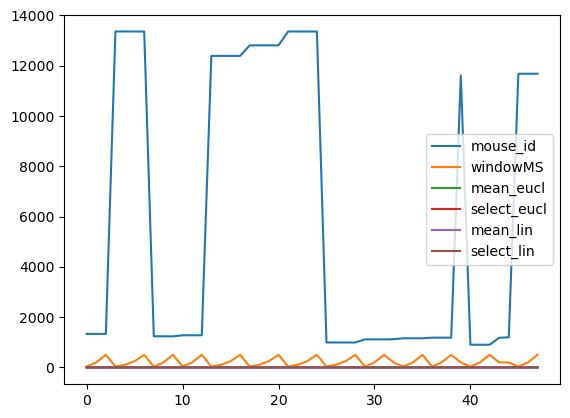

In [34]:
%matplotlib inline
results_df.plot()

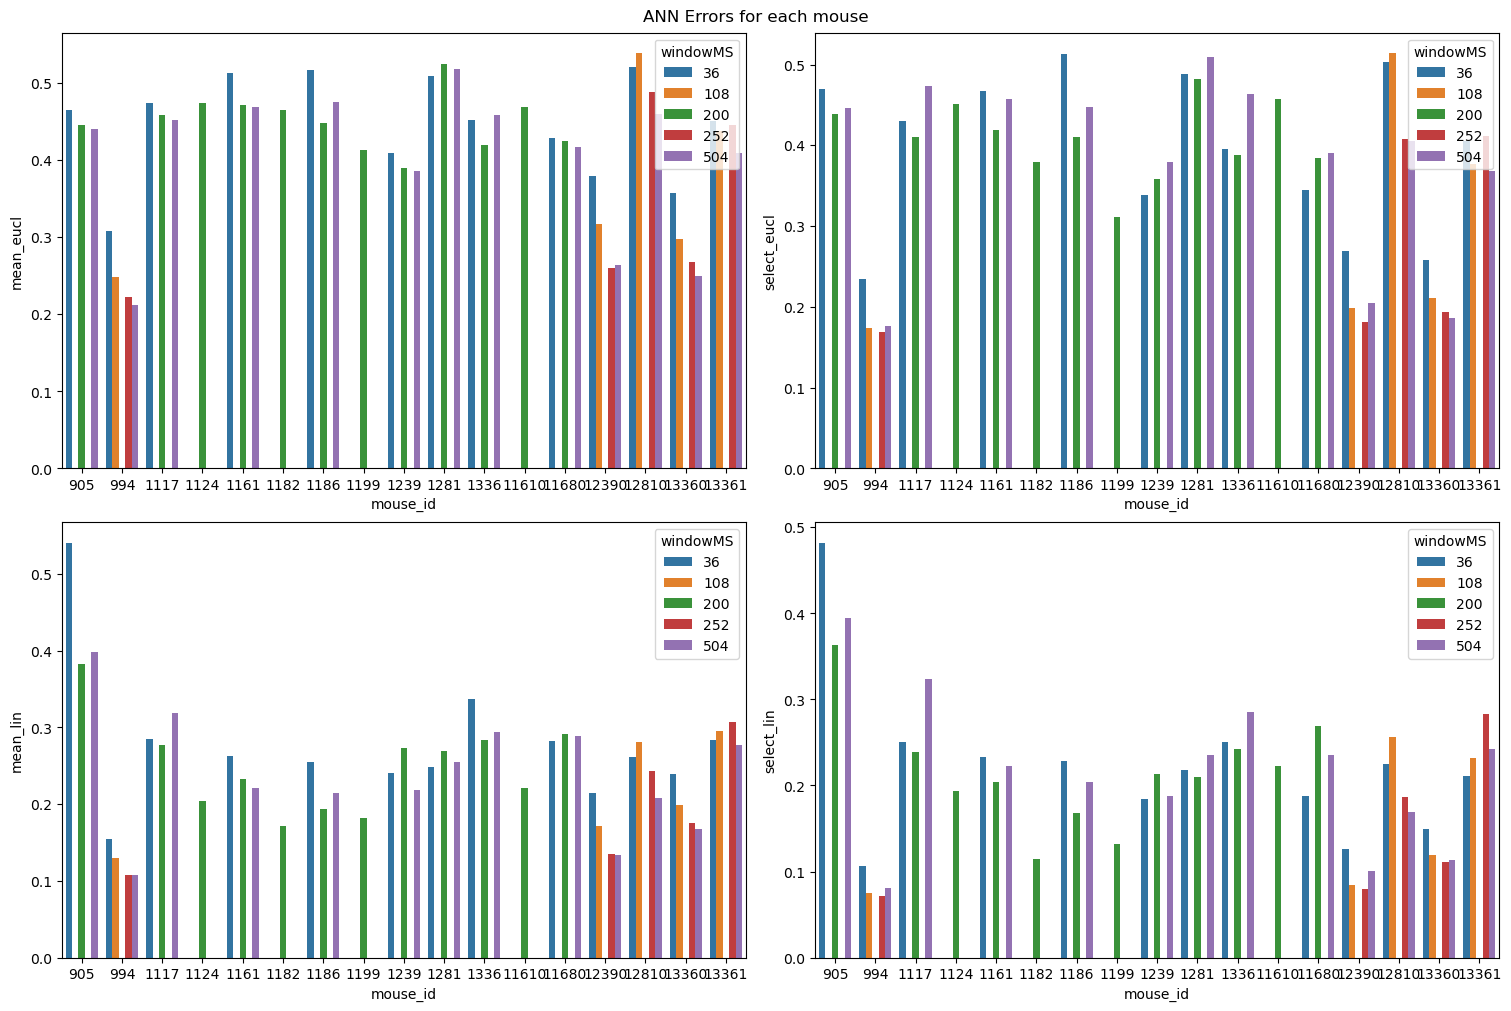

In [43]:
%matplotlib inline
fig, _axs = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)
axs = _axs.flatten()
for i, metric in enumerate(["mean_eucl", "select_eucl", "mean_lin", "select_lin"]):
    sns.barplot(hue="windowMS", y=metric, x="mouse_id", data=results_df, ax=axs[i])

fig.suptitle("ANN Errors for each mouse")

plt.show()

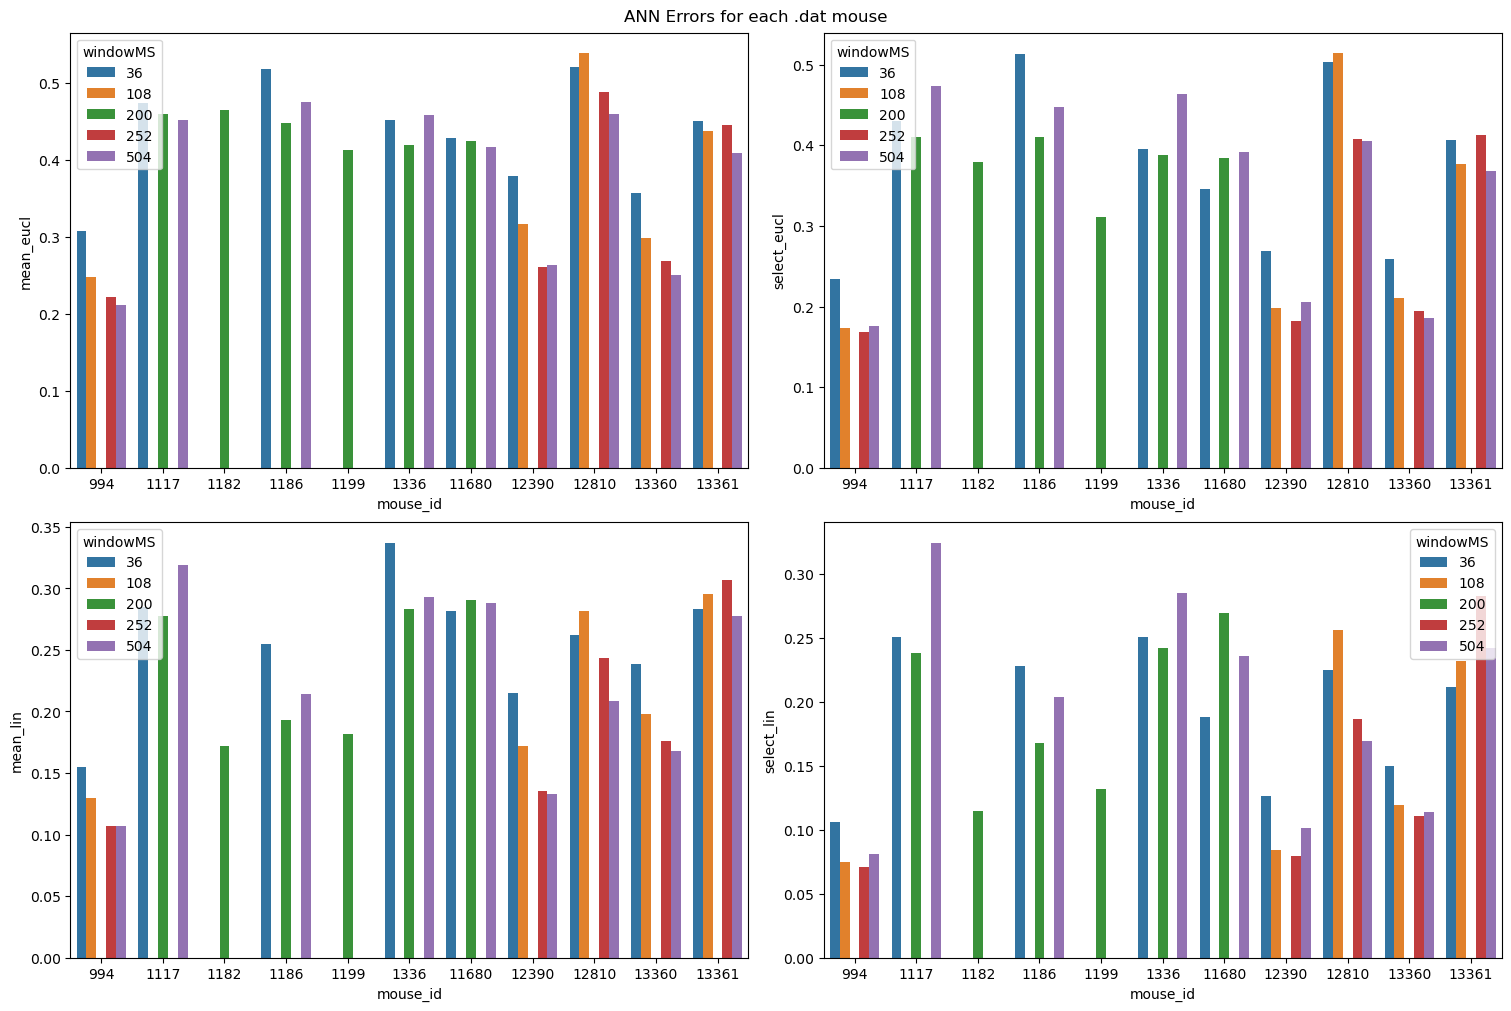

In [44]:
%matplotlib inline
fig, _axs = plt.subplots(2, 2, figsize=(15, 10), constrained_layout=True)
axs = _axs.flatten()
for i, metric in enumerate(["mean_eucl", "select_eucl", "mean_lin", "select_lin"]):
    sns.barplot(
        hue="windowMS",
        y=metric,
        x="mouse_id",
        data=results_df[results_df.has_dat == True],
        ax=axs[i],
    )

fig.suptitle("ANN Errors for each .dat mouse")
plt.show()

In [27]:
for cdt in conditions:
    for mouse in conditions[cdt]:
        results_df.loc[results_df.mouse_id == mouse, "condition"] = cdt

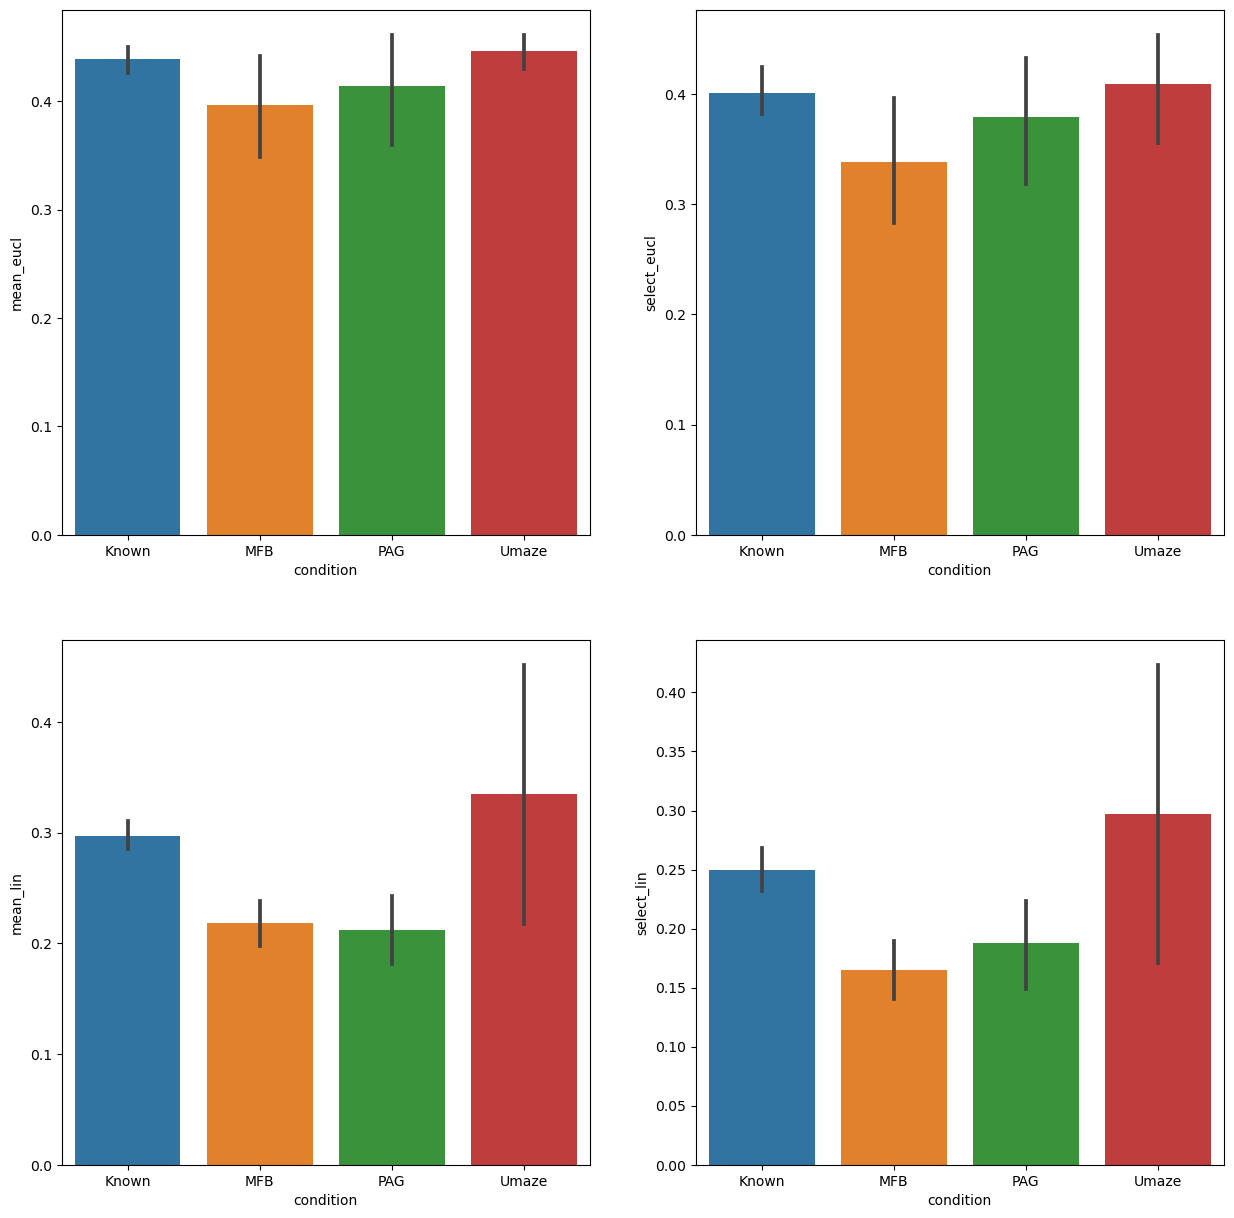

In [28]:
fig, _axs = plt.subplots(2, 2, figsize=(15, 15))
axs = _axs.flatten()
for i, metric in enumerate(["mean_eucl", "select_eucl", "mean_lin", "select_lin"]):
    sns.barplot(y=metric, x="condition", data=results_df, ax=axs[i])

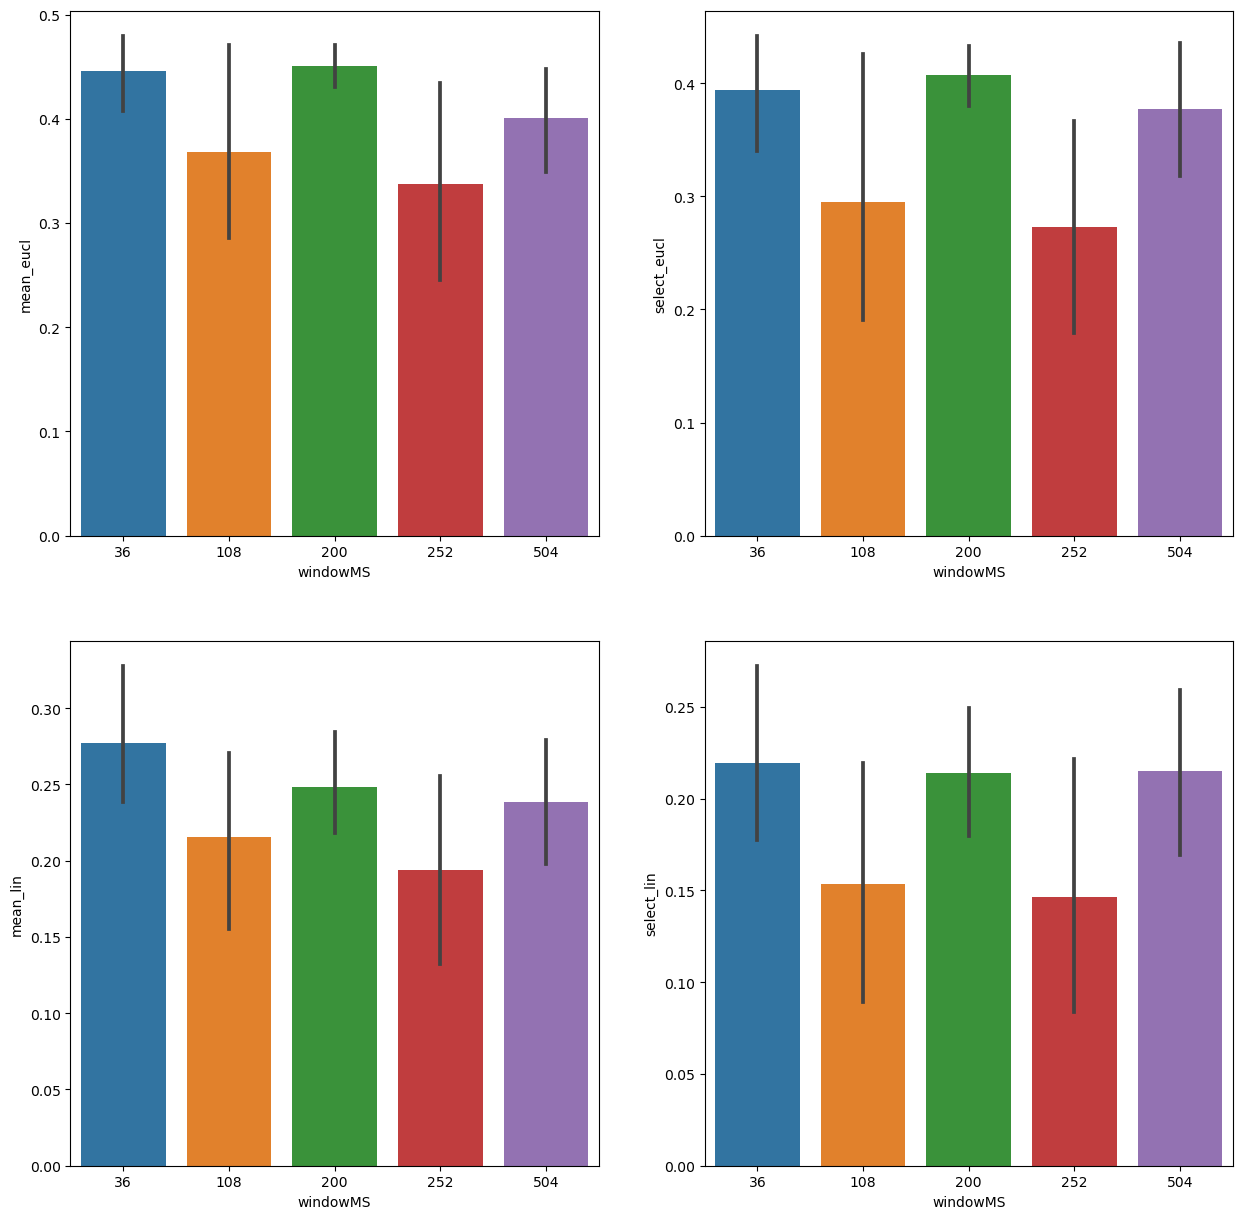

In [29]:
fig, _axs = plt.subplots(2, 2, figsize=(15, 15))
axs = _axs.flatten()
for i, metric in enumerate(["mean_eucl", "select_eucl", "mean_lin", "select_lin"]):
    sns.barplot(y=metric, x="windowMS", data=results_df, ax=axs[i])

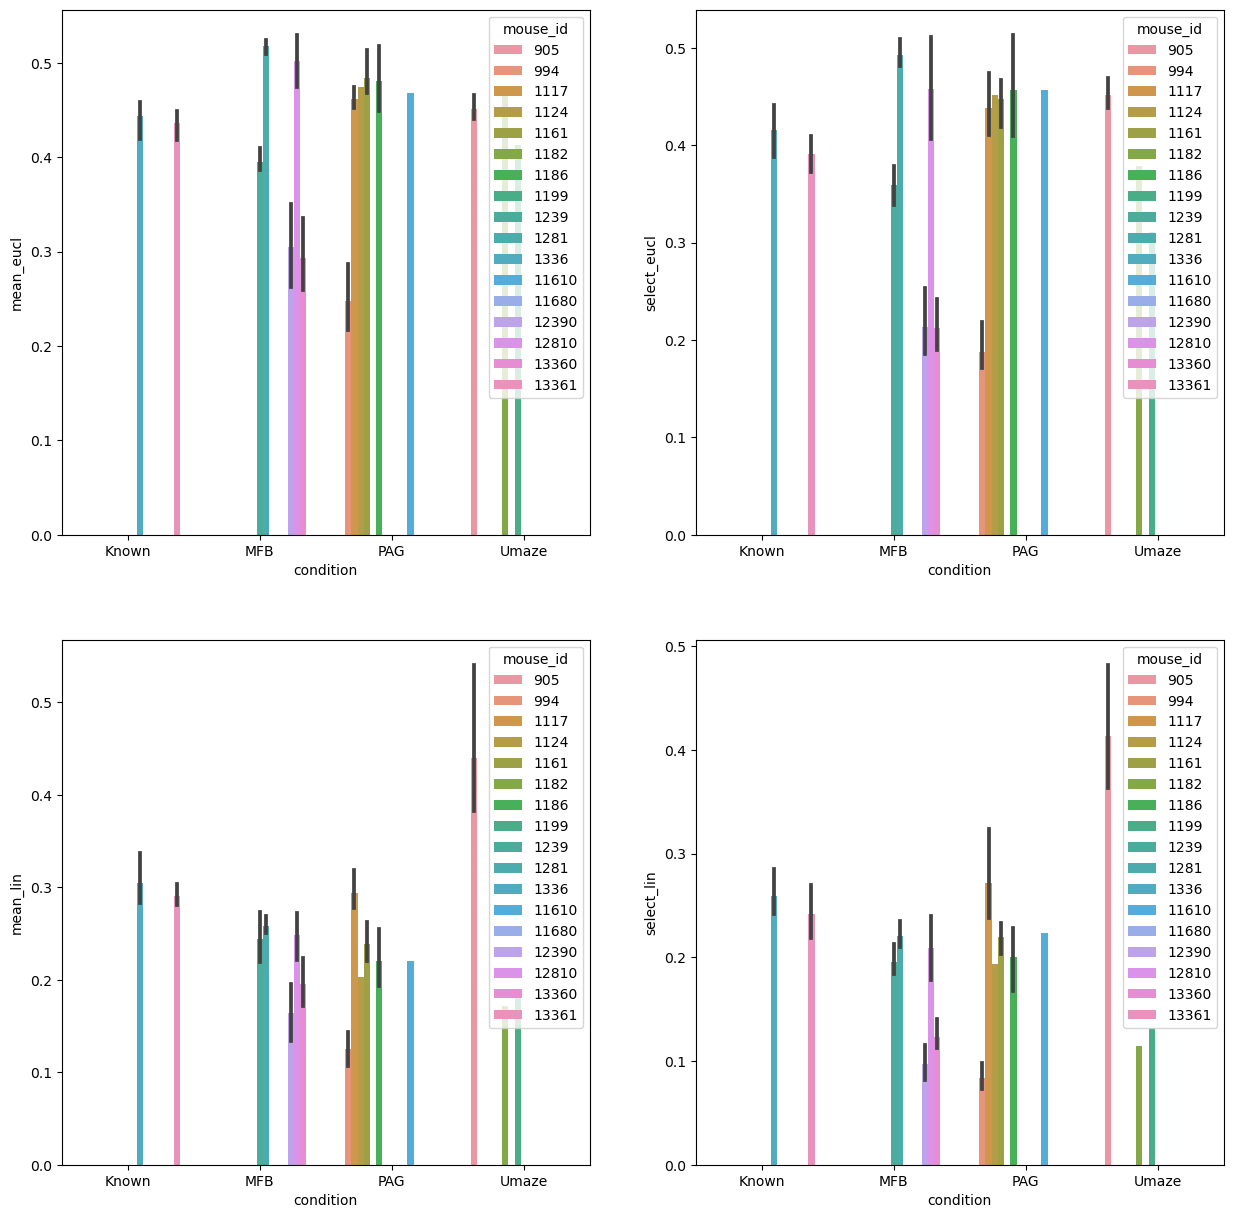

In [30]:
fig, _axs = plt.subplots(2, 2, figsize=(15, 15))
axs = _axs.flatten()
for i, metric in enumerate(["mean_eucl", "select_eucl", "mean_lin", "select_lin"]):
    sns.barplot(y=metric, x="condition", data=results_df, hue="mouse_id", ax=axs[i])

In [31]:
list_windows

[36, 108, 200, 252, 504]

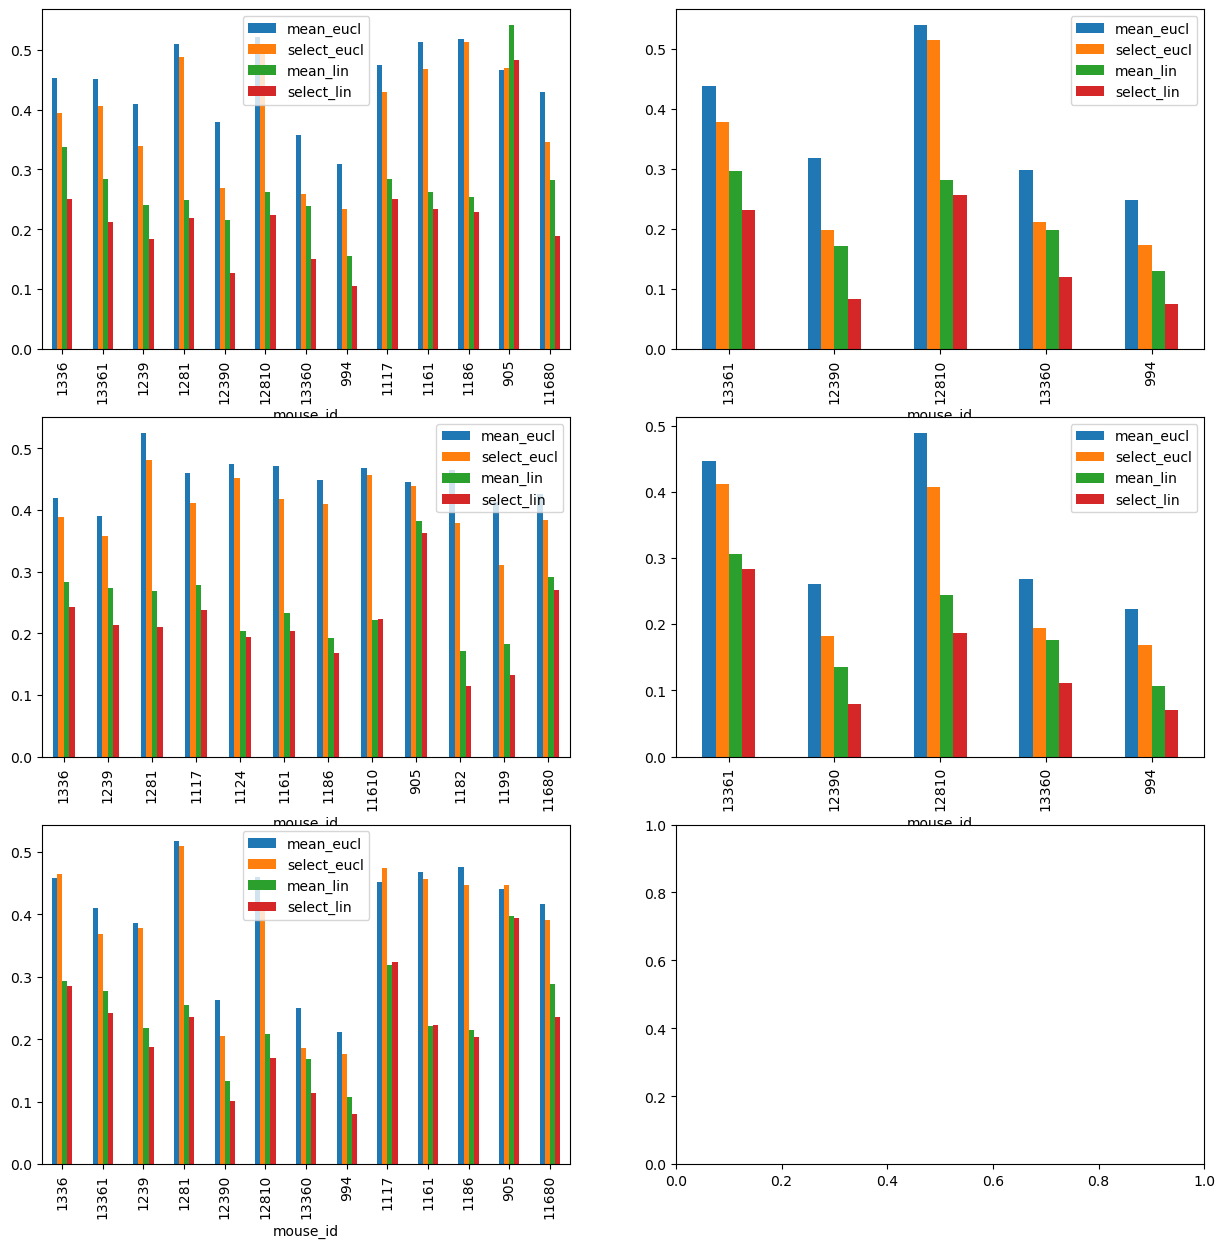

In [32]:
fig, _axs = plt.subplots(3, 2, figsize=(15, 15))
axs = _axs.flatten()
for i, windowMS in enumerate(list_windows):
    results_df[results_df.windowMS == windowMS][
        ["mouse_id", "mean_eucl", "select_eucl", "mean_lin", "select_lin"]
    ].plot.bar(x="mouse_id", ax=axs[i])

<AxesSubplot: >

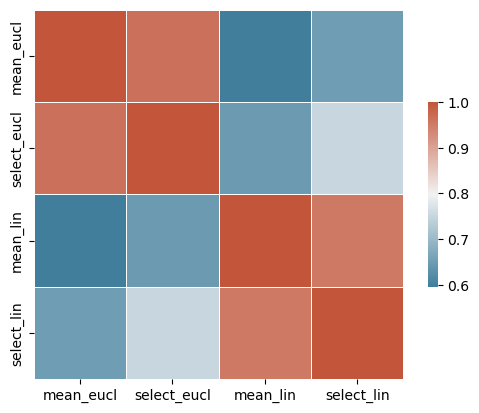

In [33]:
corr = results_df[["mean_eucl", "select_eucl", "mean_lin", "select_lin"]].corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

/tmp/ipykernel_20574/1088820411.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = results_df.corr()


<AxesSubplot: >

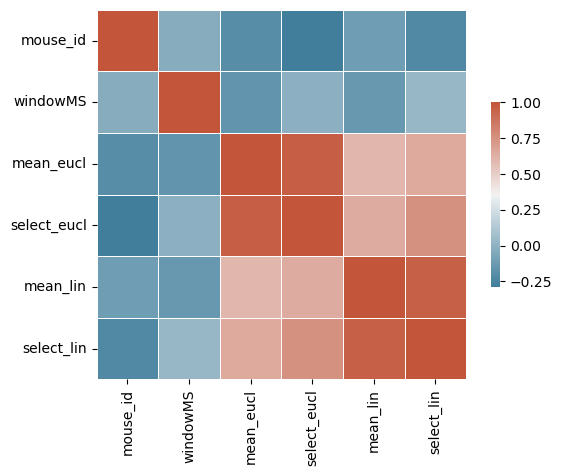

In [34]:
corr = results_df.corr()
# mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corr, cmap=cmap, square=True, linewidths=0.5, cbar_kws={"shrink": 0.5})

## Let's focus on M994 and 12390 (good results, PAG & MFB, several windowMS)

In [35]:
selected_mice = [994, 12390]

In [36]:
subresults_df = results_df[results_df["mouse_id"].isin(selected_mice)]

<AxesSubplot: >

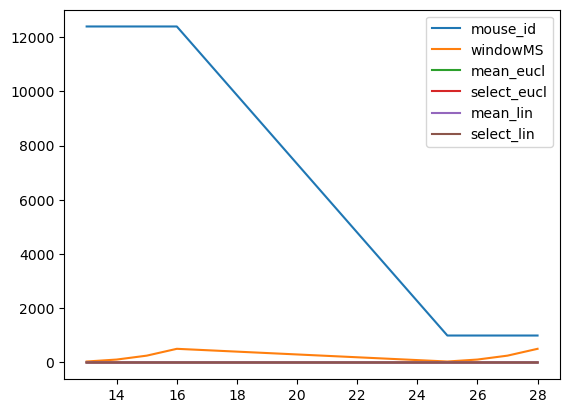

In [37]:
subresults_df.plot()

In [38]:
import spikeinterface as si
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.postprocessing as spost
import spikeinterface.curation as scur
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics

In [39]:
dirmouse

{1239: '/home/mickey/Documents/Theotime/DimaERC2/TEST3_Basile_M1239/TEST/results',
 1281: '/home/mickey/Documents/Theotime/DimaERC2/TEST3_Basile_1281MFB/TEST/results',
 1199: '/home/mickey/Documents/Theotime/DimaERC2/TEST1_Basile/TEST/results',
 1336: '/home/mickey/Documents/Theotime/DimaERC2/Known_M1336/TEST/results',
 1168: '/home/mickey/Documents/Theotime/DimaERC2/DataERC2/M1168/TEST/results',
 905: '/home/mickey/Documents/Theotime/DimaERC2/DataERC2/M905/TEST/results',
 11610: '/home/mickey/Documents/Theotime/DimaERC2/DataERC2/M1161/TEST_with_1199_model/results',
 1161: '/home/mickey/Documents/Theotime/DimaERC2/DataERC2/M1161/TEST initial/results',
 1124: '/home/mickey/Documents/Theotime/DimaERC2/DataERC2/M1124/TEST/results',
 1186: '/home/mickey/Documents/Theotime/DimaERC2/DataERC2/M1186/TEST/results',
 1182: '/home/mickey/Documents/Theotime/DimaERC2/DataERC2/M1182/TEST/results',
 11680: '/home/mickey/Documents/Theotime/DimaERC2/DataERC1/M1168/TEST/results',
 1117: '/home/mickey/Do

In [40]:
sorting_folder = dict()
from pathlib import Path

for mouse in selected_mice:
    sorting_folder[mouse] = os.path.join(Path(dirmouse[mouse]).parents[1])

In [41]:
sorting_folder

{994: '/home/mickey/Documents/Theotime/DimaERC2/neuroencoders_1021/_work/M994_PAG',
 12390: '/home/mickey/Documents/Theotime/DimaERC2/neuroencoders_1021/_work/M1239_MFB'}

In [42]:
recording = se.NeuroScopeRecordingExtractor(
    os.path.join(sorting_folder[994], "M994_20191013_UMaze_SpikeRef.dat")
)

In [43]:
import xml.etree.ElementTree as ET

tree = ET.parse(os.path.join(sorting_folder[994], "M994_20191013_UMaze_SpikeRef.xml"))
root = tree.getroot()

In [44]:
print(root.findall("anatomicalDescription"))

[<Element 'anatomicalDescription' at 0x751af38349f0>]


In [45]:
print(recording)

NeuroScopeRecordingExtractor: 135 channels - 20.0kHz - 1 segments - 401,633,280 samples 
                              20,081.66s (5.58 hours) - int16 dtype - 100.99 GiB
  file_path: /home/mickey/Documents/Theotime/DimaERC2/neuroencoders_1021/_work/M994_PAG/M994_20191013_UMaze_SpikeRef.dat


In [46]:
recording

NeuroScopeRecordingExtractor: 135 channels - 20.0kHz - 1 segments - 401,633,280 samples 
                              20,081.66s (5.58 hours) - int16 dtype - 100.99 GiB
  file_path: /home/mickey/Documents/Theotime/DimaERC2/neuroencoders_1021/_work/M994_PAG/M994_20191013_UMaze_SpikeRef.dat

In [47]:
sorting = se.NeuroScopeSortingExtractor(os.path.join(sorting_folder[994]))

In [48]:
sorting

NeuroScopeSortingExtractor: 96 units - 1 segments - 20.0kHz

In [51]:
from probeinterface import generate_linear_probe
from probeinterface.plotting import plot_probe

In [52]:
probe = generate_linear_probe(
    num_elec=135, ypitch=20, contact_shapes="circle", contact_shape_params={"radius": 6}
)

In [53]:
probe.set_device_channel_indices(np.arange(135))

In [54]:
recording = recording.set_probe(probe)

(<matplotlib.collections.PolyCollection at 0x7501b1203040>,
 <matplotlib.collections.PolyCollection at 0x7501b1291780>)

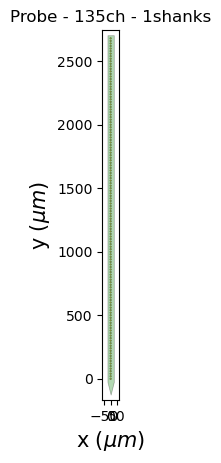

In [55]:
plot_probe(probe)

In [196]:
# let'sdo some preprocessing

%matplotlib widget
recording = spre.depth_order(recording)
recording_hp = spre.highpass_filter(recording)
recording_cmr = spre.common_reference(recording_hp)


recording_layers = dict(raw=recording, highpass=recording_hp, cmr=recording_cmr)

w = sw.plot_traces(
    recording_layers,
    mode="map",
    order_channel_by_depth=False,
    time_range=[0, 0.2],
    # figlabel="SpikeInterface tutorial: plot_traces",
    clim=(-50, 50),
    backend="ipywidgets",
)

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [217]:
si.set_global_job_kwargs(n_jobs=-1, progress_bar=True)

In [218]:
analyzer = si.create_sorting_analyzer(sorting, recording)

estimate_sparsity:   0%|          | 0/20082 [00:00<?, ?it/s]

In [219]:
required_extensions = [
    "random_spikes",
    "waveforms",
    "templates",
    "noise_levels",
    "unit_locations",
    "template_similarity",
    "spike_amplitudes",
    "correlograms",
]
analyzer.compute(required_extensions)
analyzer

compute_waveforms:   0%|          | 0/20082 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [220]:
num_spikes = sorting.count_num_spikes_per_unit()
unit_amplitudes = si.get_template_extremum_amplitude(analyzer)

analyzer.sorting.set_property("num_spikes", list(num_spikes.values()))
analyzer.sorting.set_property("amplitude", list(unit_amplitudes.values()))

In [221]:
w = sw.plot_sorting_summary(
    analyzer,
    unit_table_properties=["num_spikes", "amplitude"],
    curation=True,
    label_choices=["noise", "MUA", "SUA"],
    backend="sortingview",
)

https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=sha1://23f0c1def4391c2fc2cd80c6ba289d5e5121d865


In [223]:
%matplotlib widget

In [224]:
sw.plot_traces(recording, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [229]:
analyzer_saved = analyzer.save_as(
    folder=os.path.join(sorting_folder[994], "analyzer_for_visualization"),
)

In [238]:
analyzer_saved.compute("principal_components", n_components=3, mode="by_channel_global")
analyzer_saved.compute(
    "quality_metrics", metric_names=["snr", "amplitude_cutoff", "rp_violation"]
)
analyzer_saved

Fitting PCA:   0%|          | 0/96 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/96 [00:00<?, ?it/s]

/home/mickey/miniconda3/envs/neuroencoders/lib/python3.10/site-packages/spikeinterface/qualitymetrics/quality_metric_calculator.py:191: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  metrics.loc[non_empty_unit_ids, col] = pd.Series(res[i])


SortingAnalyzer: 135 channels - 96 units - 1 segments - memory - sparse - has recording
Loaded 10 extensions: random_spikes, waveforms, templates, noise_levels, unit_locations, template_similarity, correlograms, spike_amplitudes, principal_components, quality_metrics

In [236]:
%matplotlib widget
sw.plot_sorting_summary(analyzer_saved, backend="sortingview")

https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=sha1://d9a3e7ca56679f307089763731535b52ced01c73


In [240]:
metrics = analyzer_saved.get_extension("quality_metrics").get_data()
metrics.head(10)

,snr,amplitude_cutoff,rp_contamination,rp_violations
2,16.216147,0.017807,0.374007,523
3,16.607561,0.019746,0.071439,1
4,16.711653,0.043149,0.0,0
5,16.535566,0.02054,0.0,0
6,17.608838,0.132753,0.0,0
7,16.203859,0.022084,0.488192,42
8,16.238859,0.016513,0.130991,30
9,16.121003,0.007905,0.806386,42
10,16.43656,0.017734,0.042214,1
11,16.577167,0.025384,0.068675,83


Text(0.5, 0, 'snr')

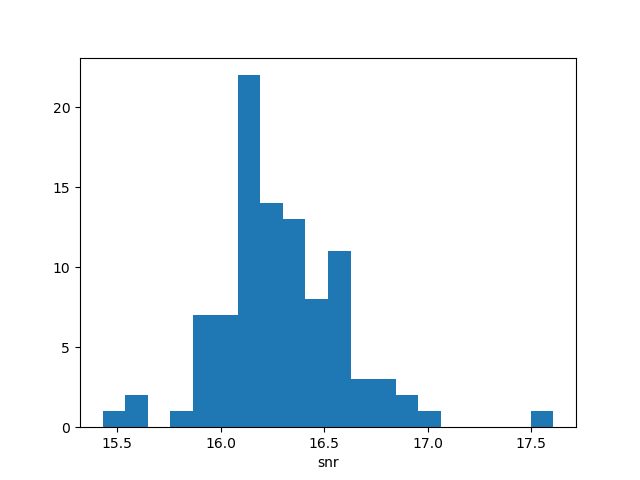

In [241]:
fig, ax = plt.subplots()
_ = ax.hist(metrics["snr"], bins=20)
ax.set_xlabel("snr")

In [56]:
sorter_names = ["spykingcircus2", "mountainsort5", "kilosort4"]

In [58]:
?run_sorter

Signature:
run_sorter(
    sorter_name: 'str',
    recording: 'BaseRecording',
    folder: 'Optional[str]' = None,
    remove_existing_folder: 'bool' = False,
    delete_output_folder: 'bool' = False,
    verbose: 'bool' = False,
    raise_error: 'bool' = True,
    docker_image: 'Optional[Union[bool, str]]' = False,
    singularity_image: 'Optional[Union[bool, str]]' = False,
    delete_container_files: 'bool' = True,
    with_output: 'bool' = True,
    output_folder: 'None' = None,
    **sorter_params,
)
Docstring:
Generic function to run a sorter via function approach.


Parameters
----------
sorter_name : str
    The sorter name
recording : RecordingExtractor
    The recording extractor to be spike sorted
folder : str or Path
    Path to output folder
remove_existing_folder : bool
    If True and folder exists then delete.
delete_output_folder : bool, default: False
    If True, output folder is deleted
verbose : bool, default: False
    If True, output is verbose
raise_error : bool

Available sorters:
-     combinato="combinato",
-     herdingspikes="herdingspikes",
-     kilosort4="kilosort4",
-     klusta="klusta",
-     mountainsort4="mountainsort4",
-     mountainsort5="mountainsort5",
-     pykilosort="pykilosort",
-     spykingcircus="spyking-circus",
-     spykingcircus2="spyking-circus2",
-     tridesclous="tridesclous",
-     yass="yass",
-     # Matlab compiled sorters:
-     hdsort="hdsort-compiled",
-     ironclust="ironclust-compiled",
-     kilosort="kilosort-compiled",
-     kilosort2="kilosort2-compiled",
-     kilosort2_5="kilosort2_5-compiled",
-     kilosort3="kilosort3-compiled",
-     waveclus="waveclus-compiled",
-     waveclus_snippets="waveclus-compiled",

In [57]:
# run sorter (if not already done)
from spikeinterface.sorters import run_sorter, read_sorter_folder

sortings = {}
for sorter_name in sorter_names:
    output_folder = Path(sorting_folder[994]) / f"Simulated_sorter_output_{sorter_name}"
    print(sorter_name, output_folder)
    if output_folder.exists():
        sortings[sorter_name] = read_sorter_folder(output_folder)
    else:
        sortings[sorter_name] = run_sorter(
            sorter_name, recording, output_folder, verbose=True
        )

/home/mickey/miniconda3/envs/neuroencoders/lib/python3.10/site-packages/numpy/core/getlimits.py:542: UserWarning: Signature b'\x00\xd0\xcc\xcc\xcc\xcc\xcc\xcc\xfb\xbf\x00\x00\x00\x00\x00\x00' for <class 'numpy.longdouble'> does not match any known type: falling back to type probe function.
This warnings indicates broken support for the dtype!
  machar = _get_machar(dtype)


spykingcircus2 /home/mickey/Documents/Theotime/DimaERC2/neuroencoders_1021/_work/M994_PAG/Simulated_sorter_output_spykingcircus2


Exception: This folder /home/mickey/Documents/Theotime/DimaERC2/neuroencoders_1021/_work/M994_PAG/Simulated_sorter_output_spykingcircus2 does not have spikeinterface_log.json